In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
%load_ext tensorboard
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from tqdm import tqdm
import itertools
from sklearn.dummy import DummyClassifier
from keras.preprocessing.sequence import pad_sequences
from pprint import pprint
from collections import defaultdict
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk import word_tokenize, sent_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import re, string, unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
from contractions import contractions_dict
from bs4 import BeautifulSoup




df = pd.read_json('Musical_Instruments_5.json', orient='records', lines=True)
#review_df.shape
df.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(10261, 9)

# Data Cleaning

In [2]:
list_pos = []
list_neg = []

for help in df['helpful']:
    list_pos.append(help[0])
    list_neg.append(help[1] - help[0])
    
df['pos_feedback'] = list_pos

df['neg_feedback'] = list_neg

df = df.drop('helpful', axis = 1)
df.shape

(10261, 10)

In [3]:
df['help_prop'] = df.pos_feedback.div((df.pos_feedback+df.neg_feedback), axis=0)
df['help_prop'].fillna(0, inplace=True)
df['rating_class'] = df['overall'].apply(lambda x: 'bad' if x < 3 else'good')
df.head()

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime,pos_feedback,neg_feedback,help_prop,rating_class
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014",0,0,0.000000,good
1,A14VAT5EAX3D9S,1384719342,Jake,The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013",13,1,0.928571,good
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013",1,0,1.000000,good
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",0,0,0.000000,good
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014",0,0,0.000000,good


In [4]:
round(df['help_prop'],1).value_counts().plot(kind='bar',xlabel = 'Helpful Ratio', ylabel = 'Count of Reviews', title = 'Count of Helpful Reviews')

<AxesSubplot:title={'center':'Count of Helpful Reviews'}, xlabel='Helpful Ratio', ylabel='Count of Reviews'>

In [5]:
#Remove Duplicate Reviews
#No Duplicate Reviews found. 
df[df.duplicated(['reviewerName','unixReviewTime','asin'],keep= False)]
#Remove NA Reveiws
#No NA Reviews Found
df = df.dropna(subset=['reviewText'])
df.shape

(10261, 12)

In [6]:
from nltk.tokenize import word_tokenize

raw_tokens=len([w for t in (df['reviewText'].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))

Number of raw tokens: 1059352


In [7]:
#Below code taken from https://github.com/umaraju18/Capstone_project_2/blob/master/code/Amazon-Headphones_data_wrangling.ipynb

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text



# Define function to expand contractions
def expand_contractions(text):

    expanded_text = contractions.fix(text)
    return expanded_text


# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = ''.join(e for e in word if e.isalnum())
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')



def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

In [8]:
def normalize_and_lemmaize(input):
    sample = denoise_text(input)
    sample = expand_contractions(sample)
    sample = remove_special_characters(sample)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [9]:
df['clean_text'] = df['reviewText'].map(lambda text: normalize_and_lemmaize(text))
df.head()

,reviewerID,asin,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime,pos_feedback,neg_feedback,help_prop,rating_class,clean_text
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014",0,0,0.000000,good,not much write exactly suppose filter pop soun...
1,A14VAT5EAX3D9S,1384719342,Jake,The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013",13,1,0.928571,good,product exactly quite affordablei not realize ...
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013",1,0,1.000000,good,primary job device block breath would otherwis...
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",0,0,0.000000,good,nice windscreen protect mxl mic prevent pop th...
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014",0,0,0.000000,good,pop filter great look perform like studio filt...


# Padding of Review Text and removal of outliers

In [10]:
clean_tokens=len([w for t in (df["clean_text"].apply(word_tokenize)) for w in t])
#clean_tokens=len((product_reviews_hp4["clean_text"]))
print('Number of clean tokens: {}\n'.format(clean_tokens))
print('Percentage of removed tokens: {0:.2f}'.format(1-(clean_tokens/raw_tokens)))

Number of clean tokens: 467232

Percentage of removed tokens: 0.56


In [11]:
from collections import Counter
clean_text = df['clean_text']
all_text2 = ' '.join(clean_text)
# create a list of words
words = all_text2.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)
print (total_words)

467232


In [12]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
reviews_int = []
for text in clean_text:
    r = [vocab_to_int[w] for w in text.split()]
    reviews_int.append(r)
print (reviews_int[0:3])

[[1, 26, 633, 275, 399, 459, 341, 4, 70, 26, 1031, 7, 1807, 19, 341, 459, 184, 158, 15, 16, 891, 12, 1127, 19], [61, 275, 144, 5742, 1, 734, 700, 538, 431, 46, 36, 9570, 138, 1212, 7, 538, 404, 82, 1848, 1061, 160, 6944, 2769, 2, 16, 9571, 3564, 1, 560, 58, 341, 459, 375, 2770, 1061, 70, 6945, 23, 341, 459, 12, 15, 172, 201, 115, 46, 39, 327, 9572, 8, 253, 9573, 61], [1408, 124, 332, 1024, 3350, 13, 730, 516, 341, 4, 259, 481, 1002, 21, 904, 2771, 127, 113, 1462, 700, 486, 459, 1024, 341, 295, 365, 481, 21, 2876, 120, 441, 229, 362, 830, 34, 570, 79, 65, 362, 2575, 128, 23, 24, 3565, 187, 58]]


In [13]:
rating_class = df['rating_class']
encoded_labels = [1 if label =='good' else 0 for label in rating_class]
encoded_labels = np.array(encoded_labels)

In [14]:
from collections import Counter
from array import array
#rev = array().fromlist(clean_text)
distinct_list= (Counter(vocab_to_int).keys())
distinct_int= (Counter(words).keys())
#print("List with distinct elements:\n",distinct_list)
print("Length of distinct list:",len(distinct_list))
print("Length of distinct reveiws_int list:",len(distinct_int))

Length of distinct list: 24870
Length of distinct reveiws_int list: 24870


In [15]:
##Determine accurate word embedding length. 
embedding_dimensions =  len(distinct_int)**0.25
print('Appropriate word embedding length for vocabulary: '+str(round(embedding_dimensions)))

Appropriate word embedding length for vocabulary: 13


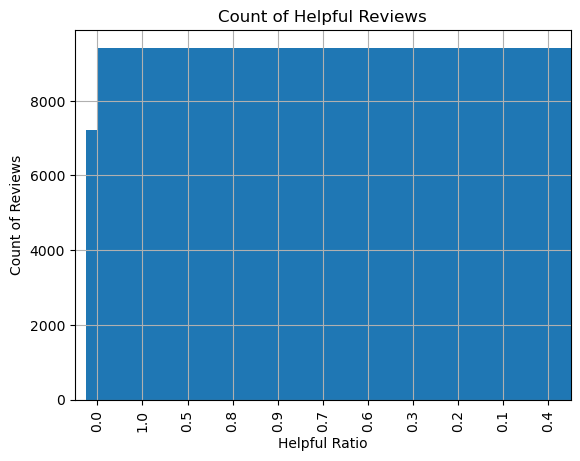

count    10261.000000
mean        45.534743
std         56.867032
min          0.000000
25%         16.000000
50%         27.000000
75%         52.000000
max       1097.000000
dtype: float64

In [16]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [17]:
print(reviews_len)

[24, 53, 46, 20, 15, 26, 19, 84, 17, 24, 103, 16, 12, 9, 8, 60, 34, 29, 139, 15, 61, 14, 18, 38, 36, 12, 19, 15, 24, 12, 16, 14, 15, 27, 44, 15, 24, 13, 14, 42, 15, 5, 20, 11, 17, 27, 13, 19, 15, 42, 37, 13, 20, 26, 13, 27, 14, 23, 18, 11, 20, 24, 12, 13, 34, 16, 11, 15, 19, 16, 18, 25, 29, 87, 15, 56, 18, 39, 15, 9, 11, 13, 75, 14, 14, 10, 11, 35, 29, 14, 15, 12, 18, 39, 13, 18, 16, 21, 93, 13, 53, 91, 35, 80, 37, 8, 23, 23, 40, 43, 48, 43, 33, 50, 30, 13, 21, 40, 40, 16, 10, 24, 24, 82, 16, 24, 16, 20, 24, 38, 15, 15, 20, 19, 19, 39, 15, 10, 32, 74, 12, 12, 17, 30, 17, 11, 11, 14, 70, 14, 23, 49, 12, 86, 63, 34, 17, 42, 34, 50, 13, 35, 12, 9, 23, 15, 11, 15, 12, 24, 13, 24, 94, 40, 56, 13, 21, 83, 25, 14, 10, 25, 15, 25, 119, 20, 321, 27, 19, 38, 142, 15, 14, 23, 243, 24, 51, 60, 70, 24, 180, 16, 10, 35, 10, 23, 95, 24, 366, 15, 88, 31, 12, 12, 24, 35, 199, 124, 25, 12, 13, 25, 35, 20, 18, 22, 437, 14, 13, 12, 37, 14, 24, 13, 61, 35, 17, 21, 13, 10, 17, 13, 21, 24, 27, 13, 28, 18, 10

In [18]:
def getCount(listOfElems, cond = None):
    'Returns the count of elements in list that satisfies the given condition'
    if cond:
        count = sum(cond(elem) for elem in listOfElems)
    else:
        count = len(listOfElems)    
    return count 
#Proposed Sequence Length below:
seq_length = 150
count = getCount(reviews_len, lambda x : x<seq_length)
print('Percent of reviews utilized with ' +str(count/len(reviews_len)))

Percent of reviews utilized with 0.9532209336321996


From this we can see that we should use a review length of 150 to catch 95% of all reviews in our sentiment analysis. 
Now we will append this to our dataframe and drop columns we don't need. 

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(reviews_int, padding='post', maxlen = 150, truncating='post')
df['reviews_int_padded'] = padded.tolist()
print(df['reviews_int_padded'])

0        [1, 26, 633, 275, 399, 459, 341, 4, 70, 26, 10...
1        [61, 275, 144, 5742, 1, 734, 700, 538, 431, 46...
2        [1408, 124, 332, 1024, 3350, 13, 730, 516, 341...
3        [33, 1661, 587, 1213, 48, 977, 341, 63, 1772, ...
4        [341, 459, 9, 25, 510, 8, 205, 459, 70, 615, 1...
                               ...                        
10256    [9, 133, 460, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
10257    [44, 38, 1506, 5, 64, 58, 113, 19, 151, 719, 2...
10258    [38, 536, 5, 549, 211, 1023, 107, 3431, 1867, ...
10259    [15, 14, 622, 1588, 890, 47, 5, 153, 90, 1827,...
10260    [5, 20, 144, 10, 13, 1, 680, 100, 4040, 5, 1, ...
Name: reviews_int_padded, Length: 10261, dtype: object


In [20]:
df['reviews_int'] = reviews_int
df['rating_int'] = encoded_labels
# Drop unnecessary columns
df1 = df.drop(['overall','reviewerName','reviewTime','unixReviewTime','summary','pos_feedback', 'neg_feedback','help_prop'], axis=1).copy()
df1.to_csv('df_clean_dataframe.csv')

In [21]:
df1['rating_class'] = df1['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)
# Splitting the Data Set into Train and Test Sets
X = padded
y = df1['rating_class'].values
train_padded, test_padded, train_labels, test_labels = train_test_split(X, y, test_size=0.25, random_state=42)
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(train_padded.shape, test_padded.shape))

Train Set Shape		:(7695, 150)
Test Set Shape		:(2566, 150)


# Begin TensorFlow Model

In [65]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
num_words = len(distinct_int)+1
seq_length = 150
emb_len = round(embedding_dimensions)
model = Sequential()

model.add(Embedding(num_words, emb_len, input_length=seq_length))


model.add(LSTM(64, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))


#optimizer = Adam(learning_rate=3e-4)
optimizer = Adam()
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 13)           323323    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                19968     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 343,356
Trainable params: 343,356
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(
    train_padded, train_labels, epochs=2, validation_data=(test_padded, test_labels),
)


Epoch 1/2
241/241 [==============================] - 11s 43ms/step - loss: 0.2068 - accuracy: 0.9519 - val_loss: 0.1891 - val_accuracy: 0.9532
Epoch 2/2
241/241 [==============================] - 10s 42ms/step - loss: 0.1845 - accuracy: 0.9549 - val_loss: 0.1889 - val_accuracy: 0.9532


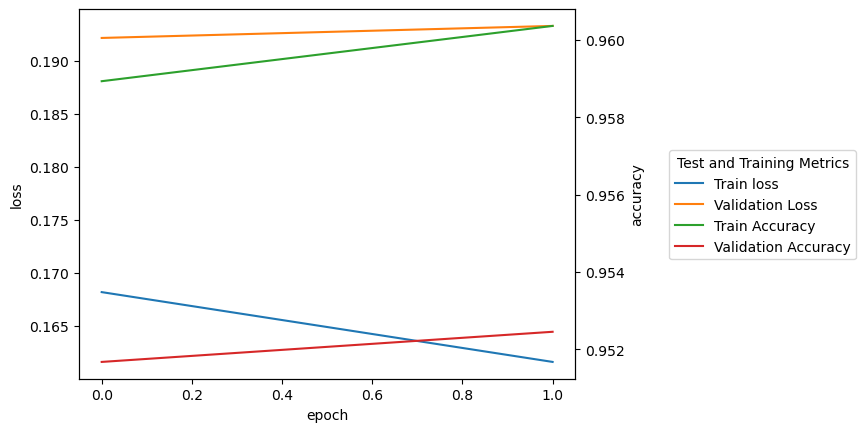

In [64]:
fig, ax1 = plt.subplots()
ax1.plot(history.history['loss'], color='C0', label = 'Train loss')
ax1.plot(history.history['val_loss'], color='C1', label = 'Validation Loss')

#ax1.title('model train vs validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
#ax1.legend(['train loss', 'validation'], loc='upper right')
ax2 = ax1.twinx()
ax2.plot(history.history['accuracy'], color='C2', label = 'Train Accuracy')
ax2.plot(history.history['val_accuracy'], color='C3', label = 'Validation Accuracy')
ax2.set_ylabel('accuracy')
#ax2.legend(['train acc', 'validation'], loc='upper right')

fig.legend(title = 'Test and Training Metrics',
           bbox_to_anchor = (1.35, 0.6))
plt.show()

In [67]:
model.save('SA_LSTM_D214_Task2')

INFO:tensorflow:Assets written to: SA_LSTM_D214_Task2\assets


INFO:tensorflow:Assets written to: SA_LSTM_D214_Task2\assets
